
## FINANCIAL ECONOMETRICS
MODULE 6 | LESSON 1

---

# **UNIT ROOT TESTS**

|  |  |
|:---|:---|
|**Reading Time** | 60 minutes |
|**Prior Knowledge** | Time Series Analysis  |
|**Keywords** | Time-stationarity, Difference-stationarity, Unit Root, Dickey Fuller test, Augmented Dickey Fuller test, Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test |


---

*In the last two modules, we learned that stationarity is a key property for time series. For example, ARMA models require the time series to be stationary before modeling. We provided conditions to ensure a time series is stationary in previous lessons. In this lesson, we will introduce some formal tests to check if a time series is stationary. We will first briefly review the definitions of strict and weak stationarities. Then, we will introduce three types of stationarity tests: Dickey-Fuller test, augmented Dickey-Fuller test, and the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test. We will finish the lesson with some examples applying these tests.*

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from arch.unitroot import ADF, KPSS 
from statsmodels.tsa.stattools import adfuller
from statsmodels.regression.linear_model import OLS
from scipy import stats
import warnings

plt.rcParams["figure.figsize"] = (16, 9)  # Figure size and width

In [2]:
# Download datasets
m6_data = pd.read_csv("M6. goog_eur_10.csv")

# Convert date variable to date format and set index
m6_data["Date2"] = pd.to_datetime(m6_data["Date"], format="%m/%d/%Y")
goog = m6_data.loc[:, ["Date2", "GOOGLE"]].set_index("Date2")

## **1. Weak and Strict Stationarity**

In Lesson 1 of  Module 4, we introduced the notions of weak stationarity and strict stationarity for time series. If a time series is weak stationary, the mean is constant and independent of time location; the autocorrelation of any two data points in the time series will only depend on the time difference but not on the time locations of the data points. For strict stationarity, the joint probability of the time series data points is the same when time shifts. 

The property of stationarity of a time series shows up in many time series models. In an ARMA model, the time series is required to be stationary before modeling. There are also coefficient restrictions in both the Box-Jenkins method and GARCH model to ensure the modeled process is stationary. We have seen the importance of being stationary for a time series.

We also learned from Module 4 that there are two methods to possibly turn a non-stationary time series into a stationary one: detrend the time series or difference the time series. If a non-stationary time series fluctuates along a straight trend in the plot, it means this time series tends to reverse back to its long-term trend after deviating from it. If we can remove this long-term trend and the detrended time series is stationary, then we call the original time series a **trend-stationary time series**.  

If we can take a first difference of a non-stationary time series and turn it into a stationary time series, we call this original time series a **difference-stationary time series**. Identifying what type of non-stationary time series we have for analysis will help us to properly prepare the data before modeling. 

In Module 4, we usually use ACF and PACF plots or time plots to check if a time series is stationary or non-stationary. Even though these visual methods are very straightforward to understand, oftentimes, these methods are very precise. In the following sections, we will introduce some formal methods to test a time series for stationarity. These methods can provide us with more rigorous checks and results for the stationary character of a time series.


## **2. Unit Root Tests**

A **unit root test** is the most popular testing method to test for stationarity for a time series. There are several methods that belong to unit root tests. In this section, we will introduce three unit root testing methods. First, let's talk about what a unit root is.


### **2.1 What are Unit Roots?**

If a time series has a unit root, the time series is not stationary. But does it have a unit root? Assume $x_t$ follows an AR(1) process:

$$ x_t = \alpha_0 + \alpha_1 x_{t-1} + v_t $$

Where $v_t$ is a stationary ARMA process with mean = $0$

If $|\alpha_1| > 1$, then $x_t$ is an explosive process. If $x_t$ follows an explosive process, it means that as time goes by, $x$ would either keep growing larger and larger or reducing more and more without bounds. Explosive processes are not seen in economics and finance, so we will exclude this scenario in this lesson.

If $|\alpha_1|=1$, then $x_t$ has unit root. We can rewrite $x_t$ as follows by iteration:

$$ x_t = \alpha_0 t + x_0 + (v_1 + v_2 + \cdots + v_t) $$

It is easy to verify that the mean and variance of $x_t$ will depend on $t$ if $x_t$ has unit root. Hence, $x_t$ is non-stationary. 

Even though $x_t$ with a unit root is non-stationary, we can take the first difference of $x_t$ and the difference will be stationary. This conclusion can easily be demonstrated from the following difference operation:

$$ x_t - x_{t-1} = \nabla x_t = v_t $$

Let's go through some terminology. A non-stationary time series that can be differenced and become a stationary one is called **integrated non-stationary process**. Specifically, a time series with one unit root is integrated with order one, or $I(1)$. In our case, $x_t$ is $I(1)$. A stationary time series with no unit root is integrated with order zero, or $I(0)$. In our case, $v_t$ is $I(0)$. If we take first difference of $I(1)$, the new time series will be $I(0)$. A non-stationary $I(d)$ time series can be differenced $d$ times and become stationary $I(0)$. We can summarize what we just described as follows:

> If $y_t\sim I(0)$, then $y_t$ is a stationary time series. <br>
> If $y_t \sim I(1)$, then $y_t - y_{t-1} = (1-B) y_t$ is a stationary time series. <br>
> If $y_t \sim I(2)$, then $ (1-B)^2 y_t$ is a stationary time series <br>

Random walk is a special case of unit root time series where $\alpha_0 = 0$ and $\alpha_1 = 1$. Random walk with a drift is also a special case of unit root time series where $\alpha_0 \neq 0$ and $\alpha_1 = 1$.


### **2.2 Dickey Fuller Test**

The first unit root test we'll discuss is the Dickey Fuller test. The Dickey Fuller test determines if unit roots exist in a time series. The Dickey Fuller test is the base of the augmented Dickey Fuller test, which we will discuss in the next section. The Dickey Fuller test can be described as follows.

For the following AR(1) process:

$$ x_t = \alpha x_{t-1} + \upsilon_t $$ 

where $\upsilon_t$ is white noise

By doing the following manipulation, we can rewrite the above equation as follows:

$$ \begin{align*}
  x_t - x_{t-1} &= \alpha x_{t-1} - x_{t-1} + \upsilon_t  \\
  \Rightarrow \nabla x_t  &= (\alpha-1) x_{t-1} + \upsilon_t  \\
  \Rightarrow \nabla x_t  &= \gamma x_{t-1} + \upsilon_t, \ \text{ where } \gamma = (\alpha-1)
\end{align*} $$

Hence, the basic Dickey Fuller test can be set up as follows:

$$ H_0: \gamma = 0 $$
$$ H_1: \gamma \neq 0 $$

The above Dickey Fuller test is equivalent to test if $\alpha=1$. However, under $H_0$, the time series is not stationary and the usual normal distribution tests do not apply. The test statistic we will use is known as a unit root test statistic or Dickey Fuller (DF) statistic. When you run a Dickey Fuller test with statistical software, it will usually provide you with the critical test values at 1%, 5%, and 10% levels. By using the two-sided hypothesis test, if you fail to reject $H_0$, this means there is a unit root for $x_t$. We will talk more about this when we demonstrate the test with an example. 

There are three main versions of Dickey Fuller tests:


**1)** $\ \nabla x_t = \gamma x_{t-1} + \upsilon_t $

The test can be written as follows:

> $ (\tau_1): \begin{cases}
  H_0: \gamma = 0 \\
  H_1: \gamma \neq 0
\end{cases} $

We just discussed this version of the test above. Under $H_0$, this test is also used to test if the process is random walk. We label this test as $\tau_1$ following Dickey and Fuller's article (Dickey and Fuller, 1979). Since there will be more versions of the Dickey Fuller test introduced in this section, it is easier to reference different versions of the test with their labels. The statistical software we will use later to demonstrate our example will also use the same labeling system for different versions of Dickey Fuller test.


**2)** $\ \nabla x_t = \gamma x_{t-1} + \alpha_0 + \upsilon_t$

This version of the equation adds a constant $\alpha_0$ to the model. This equation is the same as random walk with a drift. As there are unit roots and constants to test, we can apply two versions of the test as follows:

> a)
$ (\phi_1): \begin{cases}
  H_0: \gamma = 0, \ \alpha_0 = 0 \\
  H_1: H_0 \text{ is not true}
\end{cases}$  <br>
> 
>  b)
$ (\tau_2): \begin{cases}
  H_0: \gamma = 0 \\
  H_1: H_0 \text{ is not true}
\end{cases}$  <br>


**3)** $\ \nabla x_t = \gamma x_{t-1} + \alpha_0 + \alpha_2 t + \upsilon_t$

This version of the equation adds a constant $\alpha_0$ and a time trend $t$ to the model. As there are unit roots, constants, and time trends to test, we can apply three versions of the test as follows:

> a)
$ (\phi_2): \begin{cases}
  H_0:\gamma = 0, \ \alpha_0 = 0, \ \alpha_2 = 0  \\
  H_1: H_0 \text{ is not true}
\end{cases}$  <br>
> 
> b)
$ (\phi_3): \begin{cases}
  H_0:\gamma = 0, \ \alpha_0 = 0 \\
  H_1: H_0 \text{ is not true}
\end{cases}$  <br>
> 
> c)
$ (\tau_3): \begin{cases}
  H_0:\gamma=0 \\
  H_1: H_0 \text{ is not true}
\end{cases}$  <br>

We can see each version of the test has some restrictions on the parameters of interest. For example, $\tau_1$, $\tau_2$, and $\tau_3$ test for the presence of a unit root. $\phi_1$ and $\phi_3$ are to test for the presence of a unit root and the absence of a constant. $\phi_2$ is to test the presence of unit roots and the absence of constants and time trends. If we are not sure about the model specifications, we would usually run all of them and compare the test results. 


### **2.3 Augmented Dickey Fuller Test**

The augmented Dickey Fuller test (ADF) is the most popular unit root test to use in research. Compared to the Dickey Fuller test, the ADF test includes the lag difference terms of the time series in the equation. The reason the ADF test includes lag difference terms is to control the serial correlation in the time series of interest. We can write the three versions of ADF equations and tests as follows (we will omit $H_1$ here as they are the same as in the last section):

1) $\nabla x_t = \gamma x_{t-1} + \sum_{i=2}^{p} \beta_i \nabla x_{t-i+1} + \upsilon_t $ 

> $(\tau_1):  H_0: \gamma = 0$

2) $\nabla x_t = \gamma x_{t-1} + \alpha_0 + \sum_{i=2}^{p} \beta_i \nabla x_{t-i+1} + \upsilon_t$

> $(\phi_1) : H_0: \gamma = 0, \ \alpha_0 = 0$ <br>
> $(\tau_2) : H_0: \gamma = 0$

3) $\nabla x_t = \gamma x_{t-1} + \alpha_0 + \alpha_2 t + \sum_{i=2}^{p}\beta_i \nabla x_{t-i+1} + \upsilon_t$

> $(\phi_2):  H_0: \gamma = 0, \ \alpha_0 = 0, \ \alpha_2 = 0$ <br>
> $(\phi_3):  H_0: \gamma = 0, \ \alpha_0 = 0$  <br>
> $(\tau_3): H_0: \gamma = 0$ <br>


The versions of the ADF test are similar to the Dickey Fuller test, except that now we need to find the optimal lag order $p$ for the equation. The software we use will automatically search for the optimal $p$ based on the information criteria (AIC or BIC) we select for the test. 


### **2.4 Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test**

The KPSS test is a popular stationary test. It is usually used as a complement to unit root tests. The KPSS test determines whether there is a time trend (or deterministic trend) in the time series. In the beginning of the lesson, we learned a time series with only a time trend and white noise is trend stationary. Hence, KPSS can be described as a test if a time series is trend stationary. The KPSS test can be stated as follows:

> $H_0:$ the time series is trend stationary <br>
> $H_1:$ the time series is not trend stationary <br>

We can see that $H_0$ for the KPSS test and the ADF test show different hypotheses for the status of stationarity. $H_0$ for KPSS states that the time series is stationary while $H_0$ for ADF states that there is a unit root, so the time series is not stationary. Hence, be careful in reading the test results from different tests. 

We can run both an ADF test and KPSS test to better understand the behavior of the time series. 

> a. If the ADF test cannot reject $H_0$ and the KPSS test rejects $H_0$ $\Rightarrow $, then the time series is non-stationary. <br>
> b. If the ADF test rejects $H_0$ and the KPSS test cannot reject $H_0$ $\Rightarrow $, then the time series is trend stationary. <br>
> c. For other results, we will need to do more investigation.  <br>


### **2.5 After Unit Root Test**

Once we conclude that a time series is non-stationary after a unit root test or a stationary test, we can take the necessary steps to make it stationary. If a time series has unit roots, we can take the first difference of the time series and then check the new time series again with a unit root test. It is an iterative process until the time series has no unit root and is stationary. Also, if there is a time trend, we can implement the regression method to remove the trend. Once we are sure the time series is stationary, we can move on to build an ARMA model or conduct the next analysis.


## **3. Unit Root Test Application: Google Stock Price**

In this section, we are going to look into Google's stock price and run both ADF and KPSS tests on it. The time range of the time series is from 2016 to 2021. Let's look at the plot of Google's stock price first.


**Figure 1: Google Stock Price Plot from 2016 to 2021**


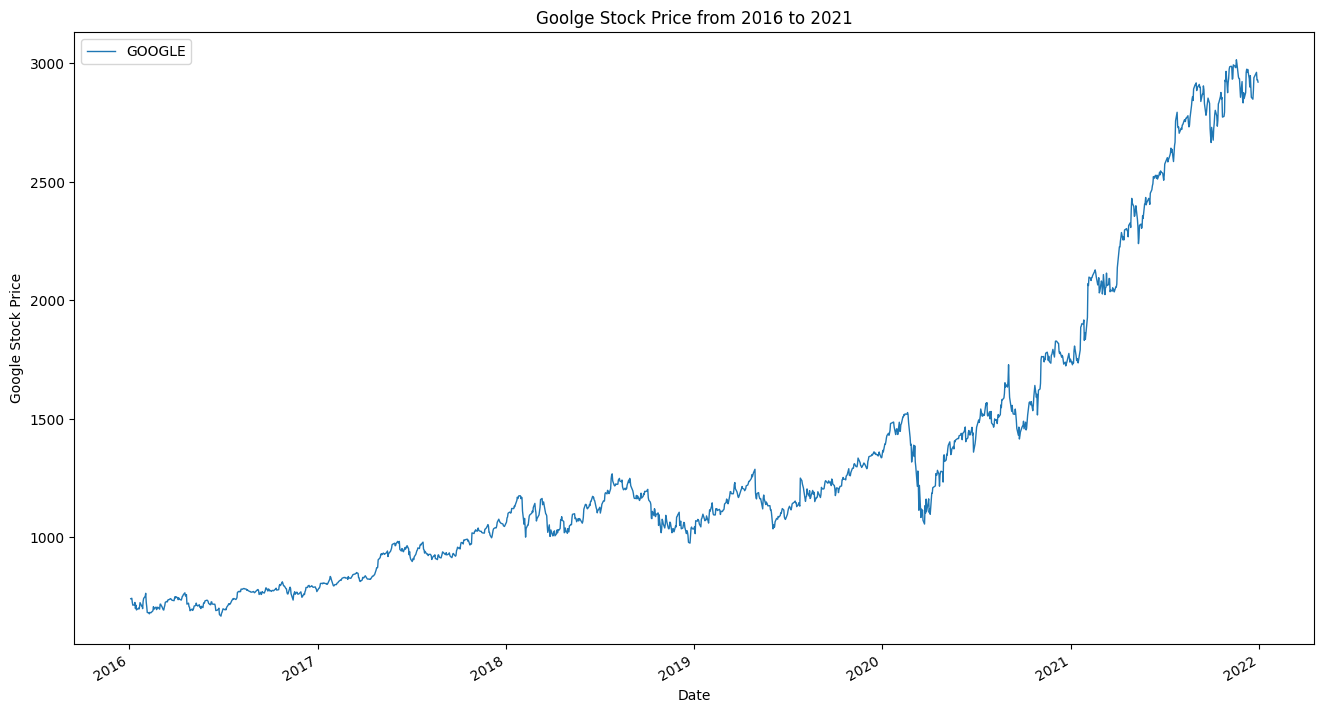

In [3]:
# Plot Google price time series chart
goog.plot(
    linewidth=1,
    xlabel="Date",
    ylabel="Google Stock Price",
    title="Goolge Stock Price from 2016 to 2021",
)
plt.show()

From the above Google price chart, we can see that Google's stock price grows at an exponential rate. Let's do three versions of the ADF and KPSS tests and see the results.


In [4]:
# Create an customized ADF test function similar to ut.df function from R
def ADF_test(data, test_type='none', maxlag=None, autolag='BIC'):
    """
    Perform Dickey-Fuller/Augmented Dickey-Fuller test with all relevant test statistics
    following the theoretical framework from Dickey and Fuller (1979)
    
    Parameters:
    - data: time series data (pandas Series or DataFrame)
    - test_type: 'none' (no constant, no trend), 'drift' (constant), 'trend' (constant + trend)
    - maxlag: maximum number of lags to test
    - autolag: method for automatic lag selection ('BIC', 'AIC', 't-stat')
    
    The three main versions:
    1) ∇x_t = γx_{t-1} + υ_t                           (test_type='none')
    2) ∇x_t = γx_{t-1} + α_0 + υ_t                    (test_type='drift') 
    3) ∇x_t = γx_{t-1} + α_0 + α_2*t + υ_t           (test_type='trend')
    """
    
    # Clean and prepare data
    if hasattr(data, 'dropna'):
        clean_data = data.dropna()
    else:
        clean_data = pd.Series(data).dropna()
    
    # Extract values as 1D array
    if hasattr(clean_data, 'values'):
        y = clean_data.values.flatten()
    else:
        y = np.array(clean_data).flatten()
    
    # Map test_type to statsmodels regression parameter
    regression_map = {
        'none': 'n',    # no constant, no trend
        'drift': 'c',    # constant only
        'trend': 'ct'    # constant and trend
    }
    
    regression = regression_map[test_type]
    
    # Basic ADF test using statsmodels
    try:
        adf_result = adfuller(y, regression=regression, maxlag=maxlag, autolag=autolag)
        lags_used = adf_result[2]
        
        # Create basic result structure
        result = {
            'test_type': test_type,
            'model_equation': get_model_equation(test_type),
            'adf_statistic': adf_result[0],
            'adf_pvalue': adf_result[1],
            'lags_used': lags_used,
            'n_observations': adf_result[3],
            'critical_values': adf_result[4],
            'ic_best': adf_result[5] if len(adf_result) > 5 else None
        }
        
        # Try to add enhanced regression results and test statistics
        try:
            enhanced_results = calculate_enhanced_statistics(y, test_type, lags_used)
            result.update(enhanced_results)
        except Exception as e:
            # If enhanced calculation fails, just use basic ADF results
            result['enhancement_error'] = str(e)
            
        return result
        
    except Exception as e:
        return {
            'test_type': test_type,
            'error': f"ADF test failed: {str(e)}"
        }

def calculate_enhanced_statistics(y, test_type, lags_used):
    """Calculate enhanced test statistics (tau and phi) with proper regression"""
    
    # Create first differences and lagged level
    dy = np.diff(y)
    y_lag1 = y[:-1]
    
    # Handle lagged differences for ADF extension
    if lags_used > 0:
        # Create lagged differences
        lagged_diffs = []
        for lag in range(1, lags_used + 1):
            lagged_diffs.append(dy[:-lag])
        
        # Align all arrays to same length
        min_length = len(dy) - lags_used
        dy_final = dy[lags_used:][:min_length]
        y_lag1_final = y_lag1[lags_used:][:min_length]
        
        # Stack lagged differences and trim to match
        if lagged_diffs:
            lagged_dy = np.column_stack([ld[-min_length:] for ld in lagged_diffs])
        else:
            lagged_dy = None
    else:
        dy_final = dy
        y_lag1_final = y_lag1
        lagged_dy = None
    
    # Build regression matrix
    if test_type == 'none':
        # Model: ∇x_t = γx_{t-1} + υ_t
        if lagged_dy is not None:
            X = np.column_stack([y_lag1_final, lagged_dy])
            var_names = ['gamma'] + [f'dy_lag{i+1}' for i in range(lags_used)]
        else:
            X = y_lag1_final.reshape(-1, 1)
            var_names = ['gamma']
            
    elif test_type == 'drift':
        # Model: ∇x_t = γx_{t-1} + α_0 + υ_t
        if lagged_dy is not None:
            X = np.column_stack([np.ones(len(dy_final)), y_lag1_final, lagged_dy])
            var_names = ['alpha_0', 'gamma'] + [f'dy_lag{i+1}' for i in range(lags_used)]
        else:
            X = np.column_stack([np.ones(len(dy_final)), y_lag1_final])
            var_names = ['alpha_0', 'gamma']
            
    elif test_type == 'trend':
        # Model: ∇x_t = γx_{t-1} + α_0 + α_2*t + υ_t
        trend = np.arange(1, len(dy_final) + 1)
        if lagged_dy is not None:
            X = np.column_stack([np.ones(len(dy_final)), trend, y_lag1_final, lagged_dy])
            var_names = ['alpha_0', 'alpha_2', 'gamma'] + [f'dy_lag{i+1}' for i in range(lags_used)]
        else:
            X = np.column_stack([np.ones(len(dy_final)), trend, y_lag1_final])
            var_names = ['alpha_0', 'alpha_2', 'gamma']
    
    # Run OLS regression
    model = OLS(dy_final, X).fit()
    
    # Extract basic regression results
    coefficients = dict(zip(var_names, model.params))
    std_errors = dict(zip(var_names, model.bse))
    t_statistics = dict(zip(var_names, model.tvalues))
    p_values = dict(zip(var_names, model.pvalues))
    
    # Calculate test statistics
    test_statistics = {}
    
    if test_type == 'none':
        # τ₁ test: H₀: γ = 0
        gamma_t = t_statistics['gamma']
        test_statistics['tau1'] = {
            'statistic': gamma_t,
            'critical_value_5pct': -1.95,  # Approximate 5% critical value for τ₁
            'null_hypothesis': 'γ = 0 (unit root exists)',
            'alternative_hypothesis': 'γ ≠ 0 (stationary)',
            'interpretation': 'Tests for unit root in random walk model'
        }
        
    elif test_type == 'drift':
        # τ₂ test: H₀: γ = 0
        gamma_t = t_statistics['gamma']
        test_statistics['tau2'] = {
            'statistic': gamma_t,
            'critical_value_5pct': -2.86,  # Approximate 5% critical value for τ₂
            'null_hypothesis': 'γ = 0 (unit root exists)',
            'alternative_hypothesis': 'γ ≠ 0 (stationary)',
            'interpretation': 'Tests for unit root in random walk with drift model'
        }
        
        # φ₁ test: H₀: γ = 0 AND α₀ = 0
        try:
            R_matrix = np.array([[1, 0], [0, 1]])  # Test first two coefficients
            if lagged_dy is not None:
                R_full = np.zeros((2, len(coefficients)))
                R_full[:2, :2] = R_matrix
                R_matrix = R_full
            phi1_test = model.f_test(R_matrix)
            test_statistics['phi1'] = {
                'statistic': phi1_test.fvalue,
                'critical_value_5pct': 3.17,
                'null_hypothesis': 'γ = 0 AND α₀ = 0 (unit root AND no drift)',
                'alternative_hypothesis': 'γ ≠ 0 OR α₀ ≠ 0 (stationary OR drift exists)',
                'interpretation': 'Joint test for unit root and absence of constant'
            }
        except:
            test_statistics['phi1'] = {
                'statistic': np.nan,
                'error': 'F-test calculation failed'
            }
            
    elif test_type == 'trend':
        # τ₃ test: H₀: γ = 0
        gamma_t = t_statistics['gamma']
        test_statistics['tau3'] = {
            'statistic': gamma_t,
            'critical_value_5pct': -3.41,  # Approximate 5% critical value for τ₃
            'null_hypothesis': 'γ = 0 (unit root exists)',
            'alternative_hypothesis': 'γ ≠ 0 (stationary)',
            'interpretation': 'Tests for unit root in model with constant and trend'
        }
        
        # φ₂ test: H₀: γ = 0 AND α₀ = 0 AND α₂ = 0
        try:
            R_matrix = np.eye(3)  # Test first three coefficients
            if lagged_dy is not None:
                R_full = np.zeros((3, len(coefficients)))
                R_full[:3, :3] = R_matrix
                R_matrix = R_full
            phi2_test = model.f_test(R_matrix)
            test_statistics['phi2'] = {
                'statistic': phi2_test.fvalue,
                'critical_value_5pct': 4.68,
                'null_hypothesis': 'γ = 0 AND α₀ = 0 AND α₂ = 0 (unit root, no constant, no trend)',
                'alternative_hypothesis': 'At least one parameter ≠ 0',
                'interpretation': 'Joint test for unit root and absence of constant and trend'
            }
        except:
            test_statistics['phi2'] = {
                'statistic': np.nan,
                'error': 'F-test calculation failed'
            }
        
        # φ₃ test: H₀: γ = 0 AND α₀ = 0
        try:
            R_matrix = np.array([[1, 0, 0], [0, 0, 1]])  # Test constant and gamma
            if lagged_dy is not None:
                R_full = np.zeros((2, len(coefficients)))
                R_full[0, 0] = 1  # alpha_0
                R_full[1, 2] = 1  # gamma
                R_matrix = R_full
            phi3_test = model.f_test(R_matrix)
            test_statistics['phi3'] = {
                'statistic': phi3_test.fvalue,
                'critical_value_5pct': 3.17,
                'null_hypothesis': 'γ = 0 AND α₀ = 0 (unit root AND no constant)',
                'alternative_hypothesis': 'γ ≠ 0 OR α₀ ≠ 0 (stationary OR constant exists)',
                'interpretation': 'Joint test for unit root and absence of constant'
            }
        except:
            test_statistics['phi3'] = {
                'statistic': np.nan,
                'error': 'F-test calculation failed'
            }
    
    return {
        'test_statistics': test_statistics,
        'regression_results': {
            'coefficients': coefficients,
            'std_errors': std_errors,
            't_statistics': t_statistics,
            'p_values': p_values
        },
        'model_fit': {
            'r_squared': model.rsquared,
            'r_squared_adj': model.rsquared_adj,
            'fstatistic': model.fvalue,
            'f_pvalue': model.f_pvalue
        }
    }

def get_model_equation(test_type):
    """Return the model equation string for display"""
    equations = {
        'none': '∇x_t = γx_{t-1} + dy_lag(s) + υ_t',
        'drift': '∇x_t = γx_{t-1} + α_0 + dy_lag(s) + υ_t', 
        'trend': '∇x_t = γx_{t-1} + α_0 + α_2*t + dy_lag(s) + υ_t'
    }
    return equations[test_type]

def print_dickey_fuller_summary(result):
    """Print comprehensive Dickey-Fuller test results"""

    print(f"\n{'='*80}")
    print(f"AUGMENTED-DICKEY-FULLER TEST RESULTS - {result['test_type'].upper()} MODEL")
    print(f"{'='*80}")
    
    # Check for errors
    if 'error' in result:
        print(f"ERROR: {result['error']}")
        return
    
    # Basic information
    print(f"Model: {result.get('model_equation', 'N/A')}")
    print(f"Lags Used: {result.get('lags_used', 'N/A')}")
    print(f"Number of Observations: {result.get('n_observations', 'N/A')}")
    if result.get('ic_best'):
        print(f"BIC: {result['ic_best']:.6f}")
    
    # Regression results
    if 'regression_results' in result:
        print(f"\n{'='*60}")
        print("REGRESSION RESULTS")
        print(f"{'='*60}")
        
        reg = result['regression_results']
        
        print(f"{'Parameter':<12} {'Coefficient':<12} {'Std Error':<12} {'t-statistic':<12} {'p-value':<12}")
        print("-" * 68)
        
        for param in reg['coefficients'].keys():
            coef = reg['coefficients'][param]
            se = reg['std_errors'][param]
            t_stat = reg['t_statistics'][param]
            p_val = reg['p_values'][param]
            
            marker = " ← γ (unit root)" if param == 'gamma' else ""
            print(f"{param:<12} {coef:<12.6f} {se:<12.6f} {t_stat:<12.6f} {p_val:<12.6f}{marker}")
        
        # Model fit
        if 'model_fit' in result:
            fit = result['model_fit']
            print(f"\nModel Fit:")
            print(f"  R-squared: {fit['r_squared']:.6f}")
            print(f"  Adjusted R-squared: {fit['r_squared_adj']:.6f}")
            print(f"  F-statistic: {fit['fstatistic']:.6f}")


    # Enhanced test statistics
    if 'test_statistics' in result:
        print(f"\n{'='*60}")
        print("DETAILED TEST STATISTICS")
        print(f"{'='*60}")
        
        for test_name, test_info in result['test_statistics'].items():
            print(f"\n{test_name.upper()} Test:")
            
            if 'error' in test_info:
                print(f"  Error: {test_info['error']}")
                continue
                
            print(f"  H₀: {test_info['null_hypothesis']}")
            print(f"  H₁: {test_info['alternative_hypothesis']}")
            
            stat_val = test_info['statistic']
            print(f"  Test Statistic: {stat_val:.6f}")
            
            # Handle critical values for both tau and phi tests
            if 'critical_value_5pct' in test_info:
                crit_val = test_info['critical_value_5pct']
                print(f"  5% Critical Value: {crit_val}")
                
                # Decision logic for tau tests (left-tail test)
                if 'tau' in test_name:
                    if stat_val < crit_val:
                        print(f"  Decision: Reject H₀ (t-stat < critical value)")

                    else:
                        print(f"  Decision: Fail to reject H₀ (t-stat > critical value)")

                
                # Decision logic for phi tests (right-tail test)
                elif 'phi' in test_name:
                    if stat_val > crit_val:
                        print(f"  Decision: Reject H₀ (F-stat > critical value)")

                    else:
                        print(f"  Decision: Fail to reject H₀ (F-stat < critical value)")

**Figure 2: Google Stock Price, ADF Test without Drift and Trend**


In [5]:
# Google Stock Price, ADF Test without Drift and Trend
df_goog_none = ADF_test(goog, test_type='none', autolag='BIC')
print_dickey_fuller_summary(df_goog_none)


AUGMENTED-DICKEY-FULLER TEST RESULTS - NONE MODEL
Model: ∇x_t = γx_{t-1} + dy_lag(s) + υ_t
Lags Used: 1
Number of Observations: 1503
BIC: 13508.807192

REGRESSION RESULTS
Parameter    Coefficient  Std Error    t-statistic  p-value     
--------------------------------------------------------------------
gamma        0.001248     0.000410     3.047900     0.002345     ← γ (unit root)
dy_lag1      -0.089269    0.025744     -3.467602    0.000540    

Model Fit:
  R-squared: 0.012903
  Adjusted R-squared: 0.011588
  F-statistic: 9.810128

DETAILED TEST STATISTICS

TAU1 Test:
  H₀: γ = 0 (unit root exists)
  H₁: γ ≠ 0 (stationary)
  Test Statistic: 3.047900
  5% Critical Value: -1.95
  Decision: Fail to reject H₀ (t-stat > critical value)


From figure 2, we see that the ADF test's statistic is 3.048. The 5% critical value is -1.95. Hence, we cannot reject $H_0$. The conclusion is that there is a unit root in Google's stock price. 

Now let's run an ADF test with drift and see the results.


**Figure 3: Google Stock Price, ADF Test with Drift but without Trend**
<span style='color: transparent; font-size:1%'>All rights reserved WQU WorldQuant University QQQQ</span>

In [6]:
# ADF test with drift but no trend
df_goog_drift = ADF_test(goog, test_type='drift', autolag='BIC')
print_dickey_fuller_summary(df_goog_drift)


AUGMENTED-DICKEY-FULLER TEST RESULTS - DRIFT MODEL
Model: ∇x_t = γx_{t-1} + α_0 + dy_lag(s) + υ_t
Lags Used: 1
Number of Observations: 1503
BIC: 13516.069302

REGRESSION RESULTS
Parameter    Coefficient  Std Error    t-statistic  p-value     
--------------------------------------------------------------------
alpha_0      -0.454600    1.441896     -0.315279    0.752594    
gamma        0.001533     0.000992     1.545548     0.122425     ← γ (unit root)
dy_lag1      -0.089597    0.025773     -3.476457    0.000523    

Model Fit:
  R-squared: 0.009094
  Adjusted R-squared: 0.007773
  F-statistic: 6.882952

DETAILED TEST STATISTICS

TAU2 Test:
  H₀: γ = 0 (unit root exists)
  H₁: γ ≠ 0 (stationary)
  Test Statistic: 1.545548
  5% Critical Value: -2.86
  Decision: Fail to reject H₀ (t-stat > critical value)

PHI1 Test:
  H₀: γ = 0 AND α₀ = 0 (unit root AND no drift)
  H₁: γ ≠ 0 OR α₀ ≠ 0 (stationary OR drift exists)
  Test Statistic: 4.691762
  5% Critical Value: 3.17
  Decision: Reject 

From Figure 3, we can see there are two model results: $\tau_2$ and $\phi_1$. For model $\tau_2$, the ADF test statistics is 1.5455 and the 5% critical value is -2.86. Hence, we cannot reject $H_0$ that there is a unit root. For model $\phi_1$, the ADF test statistics is 4.6918 and the 5% critical value is 3.17. Hence, we reject the $H_0$ that the drift is 0. The conclusion is that we have a unit root and a drift in Google stock price. 

Next let’s run the ADF test with both drift and trend.


**Figure 4: Google Stock Price, ADF Test with Drift and Trend**


In [7]:
# ADF test with drift and trend
df_goog_trend = ADF_test(goog, test_type='trend', autolag='BIC')
print_dickey_fuller_summary(df_goog_trend)


AUGMENTED-DICKEY-FULLER TEST RESULTS - TREND MODEL
Model: ∇x_t = γx_{t-1} + α_0 + α_2*t + dy_lag(s) + υ_t
Lags Used: 1
Number of Observations: 1503
BIC: 13521.205277

REGRESSION RESULTS
Parameter    Coefficient  Std Error    t-statistic  p-value     
--------------------------------------------------------------------
alpha_0      -0.054849    1.462471     -0.037504    0.970088    
alpha_2      0.004558     0.002838     1.606160     0.108449    
gamma        -0.001353    0.002052     -0.659378    0.509754     ← γ (unit root)
dy_lag1      -0.088493    0.025768     -3.434217    0.000610    

Model Fit:
  R-squared: 0.010796
  Adjusted R-squared: 0.008816
  F-statistic: 5.453384

DETAILED TEST STATISTICS

TAU3 Test:
  H₀: γ = 0 (unit root exists)
  H₁: γ ≠ 0 (stationary)
  Test Statistic: -0.659378
  5% Critical Value: -3.41
  Decision: Fail to reject H₀ (t-stat > critical value)

PHI2 Test:
  H₀: γ = 0 AND α₀ = 0 AND α₂ = 0 (unit root, no constant, no trend)
  H₁: At least one parameter

Figure 4 shows the ADF test results for a model with drift and trend. We see that we cannot reject $H_0$ at a 5% critical value level for all three models. This means that the time trend should not be included in the model. Let's run a KPSS test to see if we get the same result.


**Figure 5: Google Stock Price, KPSS Test Result**


In [8]:
# KPSS test
# (Set lags=-1 to use the old method that only depends on the sample size)
print(KPSS(goog, trend="ct", lags=-1))

    KPSS Stationarity Test Results   
Test Statistic                  1.056
P-value                         0.000
Lags                               24
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: 0.22 (1%), 0.15 (5%), 0.12 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.


In figure 5, we can see the test results show that the $p$-value is smaller than 5%. It is a clear sign to reject $H_0$. The conclusion is Google's stock price is not trend stationary and has a unit root. 

From the above analysis, we can see Google's stock price follows a random walk with a drift model. 

Let's do the log difference transformation we mentioned in the previous module. Log difference transformation approximates to a stock return. Figure 2 shows the plot for Google's stock price with log difference transformation. 


**Figure 6: Plot of Logged Difference of Google Stock Price from 2016 to 2021**


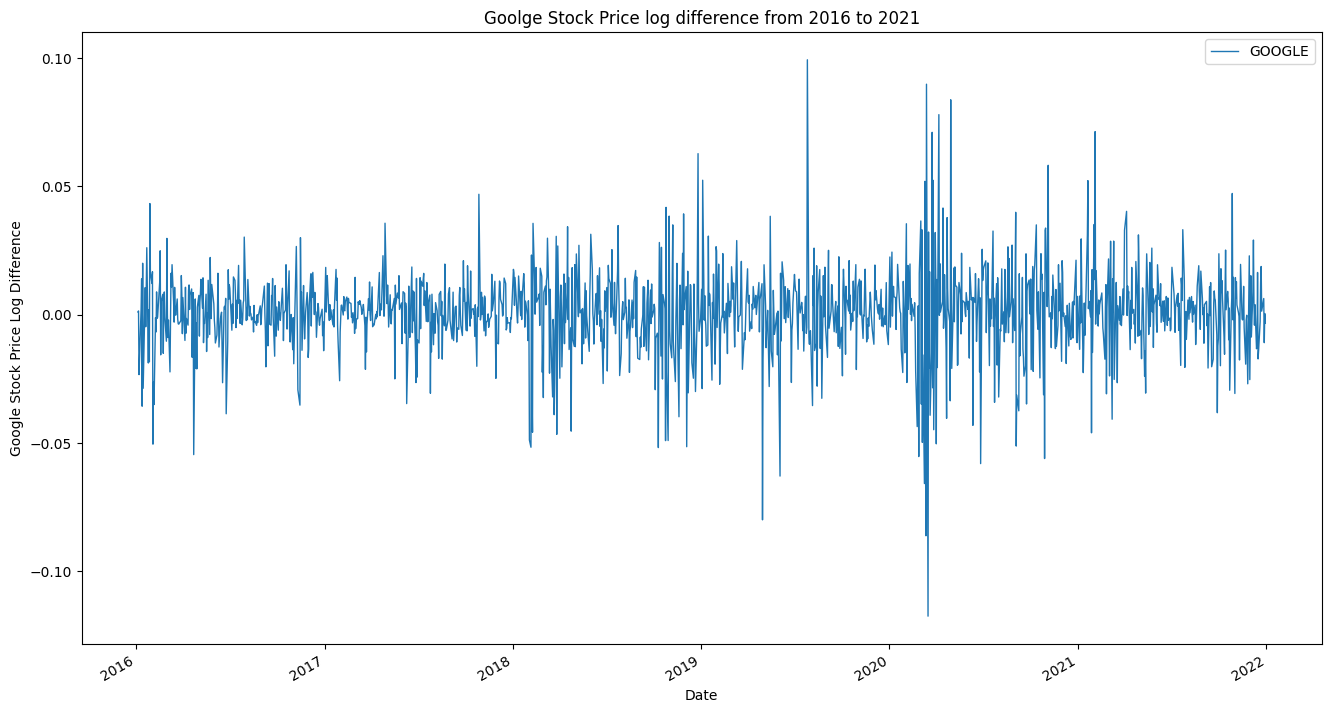

In [9]:
# Plot Google price time series chart
lgoog = np.log(goog).diff().dropna()
lgoog.plot(
    linewidth=1,
    xlabel="Date",
    ylabel="Google Stock Price Log Difference",
    title="Goolge Stock Price log difference from 2016 to 2021",
)
plt.show()

Now let's run the three versions of an ADF test for the logged difference of Google's stock price and see the results. We are only going to focus on the ADF test statistics and 5% critical values for the three models. The following table only provides the information necessary from the model results to make a decision.



**Figure 7: Three Versions of ADF Test for Logged Difference of Google Stock Price**


In [10]:
# Logged Difference of Google Stock Price, ADF Test without Drift and Trend
df_lgoog_none = ADF_test(lgoog, test_type='none', autolag='BIC')
print_dickey_fuller_summary(df_lgoog_none)


AUGMENTED-DICKEY-FULLER TEST RESULTS - NONE MODEL
Model: ∇x_t = γx_{t-1} + dy_lag(s) + υ_t
Lags Used: 0
Number of Observations: 1503
BIC: -7992.618005

REGRESSION RESULTS
Parameter    Coefficient  Std Error    t-statistic  p-value     
--------------------------------------------------------------------
gamma        -1.112520    0.025639     -43.391403   0.000000     ← γ (unit root)

Model Fit:
  R-squared: 0.556253
  Adjusted R-squared: 0.555958
  F-statistic: 1882.813856

DETAILED TEST STATISTICS

TAU1 Test:
  H₀: γ = 0 (unit root exists)
  H₁: γ ≠ 0 (stationary)
  Test Statistic: -43.391403
  5% Critical Value: -1.95
  Decision: Reject H₀ (t-stat < critical value)


In [11]:
# Logged Difference of Google Stock Price, ADF Test with Drift but without Trend
df_lgoog_drift = ADF_test(lgoog, test_type='drift', autolag='BIC')
print_dickey_fuller_summary(df_lgoog_drift)


AUGMENTED-DICKEY-FULLER TEST RESULTS - DRIFT MODEL
Model: ∇x_t = γx_{t-1} + α_0 + dy_lag(s) + υ_t
Lags Used: 0
Number of Observations: 1503
BIC: -7992.196100

REGRESSION RESULTS
Parameter    Coefficient  Std Error    t-statistic  p-value     
--------------------------------------------------------------------
alpha_0      0.001017     0.000421     2.416234     0.015801    
gamma        -1.115968    0.025638     -43.528345   0.000000     ← γ (unit root)

Model Fit:
  R-squared: 0.557973
  Adjusted R-squared: 0.557678
  F-statistic: 1894.716841

DETAILED TEST STATISTICS

TAU2 Test:
  H₀: γ = 0 (unit root exists)
  H₁: γ ≠ 0 (stationary)
  Test Statistic: -43.528345
  5% Critical Value: -2.86
  Decision: Reject H₀ (t-stat < critical value)

PHI1 Test:
  H₀: γ = 0 AND α₀ = 0 (unit root AND no drift)
  H₁: γ ≠ 0 OR α₀ ≠ 0 (stationary OR drift exists)
  Test Statistic: 947.358445
  5% Critical Value: 3.17
  Decision: Reject H₀ (F-stat > critical value)


In [12]:
# Logged Difference of Google Stock Price, ADF Test with Drift and Trend
df_lgoog_trend = ADF_test(lgoog, test_type='trend', autolag='BIC')
print_dickey_fuller_summary(df_lgoog_trend)


AUGMENTED-DICKEY-FULLER TEST RESULTS - TREND MODEL
Model: ∇x_t = γx_{t-1} + α_0 + α_2*t + dy_lag(s) + υ_t
Lags Used: 0
Number of Observations: 1503
BIC: -7985.603481

REGRESSION RESULTS
Parameter    Coefficient  Std Error    t-statistic  p-value     
--------------------------------------------------------------------
alpha_0      0.000178     0.000841     0.211640     0.832417    
alpha_2      0.000001     0.000001     1.152640     0.249242    
gamma        -1.116759    0.025644     -43.548365   0.000000     ← γ (unit root)

Model Fit:
  R-squared: 0.558364
  Adjusted R-squared: 0.557775
  F-statistic: 948.230094

DETAILED TEST STATISTICS

TAU3 Test:
  H₀: γ = 0 (unit root exists)
  H₁: γ ≠ 0 (stationary)
  Test Statistic: -43.548365
  5% Critical Value: -3.41
  Decision: Reject H₀ (t-stat < critical value)

PHI2 Test:
  H₀: γ = 0 AND α₀ = 0 AND α₂ = 0 (unit root, no constant, no trend)
  H₁: At least one parameter ≠ 0
  Test Statistic: 632.153412
  5% Critical Value: 4.68
  Decision

From figure 7, we can see that there is no unit root for the logged difference of Google's stock price. Let's run a KPSS test for the logged difference of Google's stock price as well.


**Figure 8: KPSS Test for Logged Difference of Google's Stock Price**


In [13]:
# KPSS test
# (Set lags=-1 to use the old method that only depends on the sample size)
print(KPSS(lgoog, trend="ct", lags=-1))

    KPSS Stationarity Test Results   
Test Statistic                  0.038
P-value                         0.752
Lags                               24
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: 0.22 (1%), 0.15 (5%), 0.12 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.


From figure 8, we can see that the KPSS test cannot reject $H_0$, and we can conclude that there is no unit root. From the ADF and KPSS tests, we can say that the logged difference of Google's stock price is stationary. 


## **4. Conclusion**

In this lesson, we introduced a unit root test to test for stationarity of a time series. We first described what a unit root is. We then introduced the first unit root test: the Dickey Fuller Test. We went through the basic theory and the three versions of the test. Although we do not use Dickey Fuller test as much now, it serves as a good base test to understand the next test: the augmented Dickey Fuller test. ADF is the most popular unit root test nowadays. We also went through its theory and the three versions of the test. We then discussed the KPSS test. This is another unit root test that can be used to compliment the ADF test. Finally, we used Google's stock price as an example to run through the ADF test and KPSS test. We showed how to read the results from the tests and draw conclusions. This lesson concludes our study of analysis of univariate time series or one time series. In the next few lessons, we will start to study two or more time series and analyze their interactions. 


## **References**

- Dickey, David A., and Wayne A. Fuller. "Distribution of the Estimator for Autoregressive Time Series with a Unit Root." Journal of the American Statistical Association, vol. 74, no. 366, 1979, pp. 427–431.


---
Copyright 2025 WorldQuant University. This
content is licensed solely for personal use. Redistribution or
publication of this material is strictly prohibited.
